# Importing Dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the Data 

In [3]:
ratings = pd.read_csv("ml-latest-small/ratings.csv")
movies = pd.read_csv("ml-latest-small/movies.csv")

# Exploratory Data Analysis

In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


# Distribution of movie ratings:

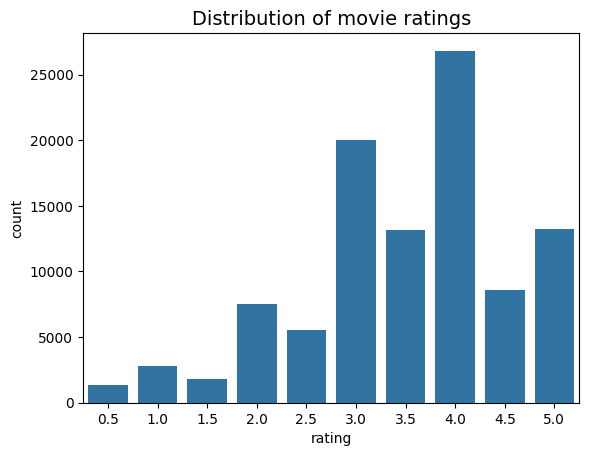

In [7]:
sns.countplot(x='rating', data=ratings)
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

# Which movies are most frequently rated?

In [8]:
movie_ratings = ratings.merge(movies, on='movieId')
movie_ratings['title'].value_counts()[0:10]

title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: count, dtype: int64

## Bayesian Average

In [9]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_stats.head()

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [10]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values(by='bayesian_avg', ascending=False)

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227,Fight Club (1999)
224,260,251,4.231076,4.193,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.191,"Usual Suspects, The (1995)"
...,...,...,...,...,...
1988,2643,16,1.687500,2.307,Superman IV: The Quest for Peace (1987)
1144,1499,27,1.925926,2.297,Anaconda (1997)
1372,1882,33,1.954545,2.267,Godzilla (1998)
2679,3593,19,1.657895,2.224,Battlefield Earth (2000)


# Dealing with the genres column

Currently like:     "Adventure|Children|Fantasy"

We need it as a list

In [11]:
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


# Colaborative Filtering

### Generating a sparse matrix

    Args:
      df (pd.DataFrame): DataFrame with columns 'userId', 'movieId', 'rating'.
    

    Returns:
      matrix (sparse matrix): The resulting user-item rating matrix.
      user_mapper (dict): Maps user IDs to matrix indices.
      user_inv_mapper (dict): Maps matrix indices back to user IDs.
      movie_mapper (dict): Maps movie IDs to matrix indices.
      movie_inv_mapper (dict): Maps matrix indices back to movie IDs.


In [12]:
from scipy.sparse import csr_matrix

def create_matrix(df):
  
    unique_users = df['userId'].nunique()
    unique_movies = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(unique_users))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(unique_movies))))
    
    user_inv_mapper = dict(zip(list(range(unique_users)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(unique_movies)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    matrix = csr_matrix((df["rating"], (user_index,item_index)), shape=(unique_users,unique_movies))
    
    return matrix, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

matrix, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_matrix(ratings)

In [13]:
matrix.shape

(610, 9724)

# Evaluating Sparsity

Matrix sparsity: 1.7%


NameError: name 'n_ratings_per_user' is not defined

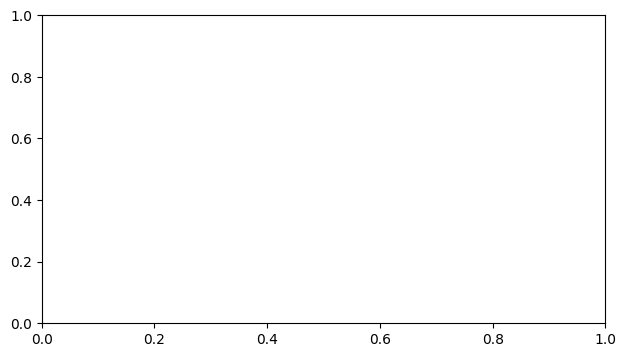

In [14]:
n_total = matrix.shape[0]*matrix.shape[1]
n_ratings = matrix.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, fill=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, fill=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

# Item-Item Recommendations with K-nearest Neighbors


    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's


In [ ]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, matrix, movie_mapper, movie_inv_mapper, k, metric='cosine'):
  
    matrix = matrix.T
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = matrix[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(matrix)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [ ]:
similar_movies = find_similar_movies(1, matrix, movie_mapper, movie_inv_mapper, k=10)
similar_movies

In [ ]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1

similar_movies = find_similar_movies(movie_id, matrix, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]
print(f"Because you watched {movie_title}:")
print(" ")
for i in similar_movies:
    print(movie_titles[i])

# Content Based Filtering

In [ ]:
genres = set(g for G in movies['genres'] for g in G)

for g in genres:
    movies[g] = movies.genres.transform(lambda X: int(g in X))

movie_genres = movies.drop(columns=['movieId', 'title', 'genres'])

In [ ]:
movie_genres

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_genres, movie_genres)
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

# Movie finder

In [ ]:
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

In [ ]:
title = movie_finder('juman')
title

In [ ]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Because you watched {title}:")
    print(movies['title'].iloc[similar_movies])

In [ ]:
get_content_based_recommendations('jumn', 5)